In [11]:
import os
import numpy as np
from astropy.io import fits
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
plt.style.use('seaborn-white')
import plotly.plotly as py
import plotly.graph_objs as go
from scipy.integrate import quad
import pandas as pd
import seaborn as sns
import cufflinks as cf
from bokeh.plotting import figure, show, output_file
directory = '/Users/zach//GRB160625B.945_LAT-trigger_correlated-optical-polarized-emission/'
file_n5 = 'glg_cspec_n5_bn160625945_v01.rsp'
#file_n7 = 'glg_tte_n7_bn160625945_v00.fit'
#file_b1 = 'glg_tte_b1_bn160625945_v00.fit'

# HDU: Header Data Unit
hdu_n5 = fits.open(directory + file_n5)
#hdu_n7 = fits.open(directory + file_n7)


# print(hdu_n5.info())
#print(repr(hdu_n5['SPECRESP MATRIX'].header))
print(hdu_n5['SPECRESP MATRIX'].columns)
#print(hdu_n5['EBOUNDS'].columns)
#print(hdu_n2['SPECRESP MATRIX'].data)

ColDefs(
    name = 'ENERG_LO'; format = '1E'; unit = 'keV'
    name = 'ENERG_HI'; format = '1E'; unit = 'keV'
    name = 'N_GRP'; format = '1I'
    name = 'F_CHAN'; format = 'PI(1)'
    name = 'N_CHAN'; format = 'PI(1)'
    name = 'MATRIX'; format = 'PE(128)'; unit = 'cm**2'
)


In [12]:
# rmf file
ENERG_LO= hdu_n5['SPECRESP MATRIX'].data['ENERG_LO']
ENERG_HI= hdu_n5['SPECRESP MATRIX'].data['ENERG_HI']
N_GRP= hdu_n5['SPECRESP MATRIX'].data['N_GRP']
F_CHAN= hdu_n5['SPECRESP MATRIX'].data['F_CHAN']
MATRIX= hdu_n5['SPECRESP MATRIX'].data['MATRIX']
# arf file 
E_MIN= hdu_n5['EBOUNDS'].data['E_MIN']
E_MAX= hdu_n5['EBOUNDS'].data['E_MAX']
CHANNEL=hdu_n5['EBOUNDS'].data['CHANNEL']


In [13]:
# create 140 energy intervals with 141 points 
EnergyArray=ENERG_LO
EnergyArray= np.append(EnergyArray,ENERG_HI[-1])

In [14]:
# Normalization factor equals to x0 
x0=100
def power_law_simulation(param,x):
    y = param[0]*((x/x0)**param[1])
    return np.array(y,dtype='float64')

Power_law_coeff=[1,-2]


In [15]:
NbPhoton_Sim= power_law_simulation(Power_law_coeff,EnergyArray)
log_NbPhoton_Sim=list(map(lambda x: math.log10(x),NbPhoton_Sim))
log_EnergyArray=list(map(lambda x: math.log10(x),EnergyArray))

In [16]:
# define my intergral function againest each energy interval. 
def integrand(x, a, b):
    
    return a * ((x/x0)**b)

a = Power_law_coeff[0]
b = Power_law_coeff[1]
Integration_at_energy=[]
for i in range(len(EnergyArray)-1):
    I = quad(integrand,EnergyArray[i],EnergyArray[i+1], args=(a,b))
    Integration_at_energy.append(I[0])
#Integration_at_energy

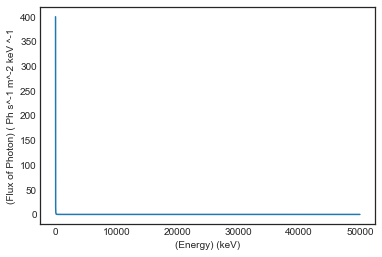

In [25]:
plt.plot(EnergyArray,NbPhoton_Sim)
plt.ylabel('(Flux of Photon) ( Ph s^-1 m^-2 keV ^-1')
plt.xlabel('(Energy) (keV)')
plt.show()

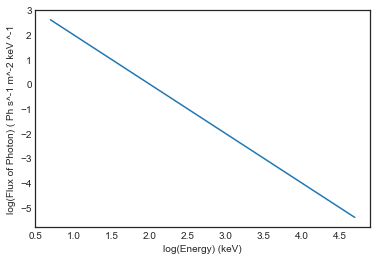

In [26]:
plt.plot(log_EnergyArray,log_NbPhoton_Sim)
plt.ylabel('log(Flux of Photon) ( Ph s^-1 m^-2 keV ^-1')
plt.xlabel('log(Energy) (keV)')
plt.show()

In [27]:
df=pd.DataFrame(EnergyArray,columns=['EnergyArray'])
df['NbPhoton_Sim']=NbPhoton_Sim
df2=pd.DataFrame(Integration_at_energy,columns=['Integration_at_energy'])
df2['Energy range']=np.arange(140)

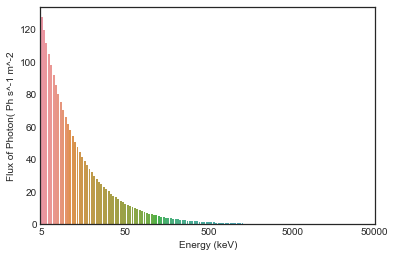

In [31]:
# Integrate against the energy. 
ax = sns.barplot(x="Energy range", y="Integration_at_energy", data=df2)
ax.set(xlabel='Energy (keV)', ylabel='Flux of Photon( Ph s^-1 m^-2')
#ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
x_pos_list = np.array([0,35,70,105,139])
x_value_list = ('5', '50', '500', '5000','50000')
ax.xaxis.set_major_locator(ticker.FixedLocator((x_pos_list)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter((x_value_list)))
plt.show()

In [32]:
# Area, second way to conduct the integral
photon_area = np.zeros(140)
for i, _ in enumerate(NbPhoton_Sim):
    if i == (len(NbPhoton_Sim) - 1):
        break
    elem = np.append(NbPhoton_Sim[i], NbPhoton_Sim[i+1])
    photon_area[i] = np.trapz(elem, dx=2)

In [33]:
matrix= np.zeros(shape=(140,128))
for i in range(len(MATRIX)):
    if MATRIX[i][0]==0:
        matrix[i]=[0]*128
    else:
        matrix[i]=MATRIX[i]
    # normalization
#for i in range(len(matrix)):
        #if matrix[i][0]!=0:
            #matrix[i] = matrix[i]/sum(matrix[i])
#print(matrix)
matrix_trans=matrix.transpose()

In [34]:
a = np.array(Integration_at_energy)
#a = np.array(photon_area)
b = matrix

In [35]:
# Derive the  140 x 120 values. 
value_list=[]
for i in range(len(matrix_trans)):
    for j in range(len(matrix_trans[i])):
        value= (Integration_at_energy[j]) * matrix_trans[i][j]
        value_list.append(value)

In [36]:
value_array=np.array(value_list)
value_matrix=value_array.reshape(128,140)
#np.sum(value_matrix[100])

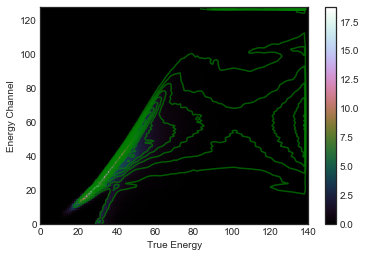

In [37]:
fig=plt.figure()
ax1=plt.pcolormesh(value_matrix, cmap=plt.get_cmap('cubehelix'))
plt.colorbar()
curves =20
m = max([max(row) for row in matrix])
levels = np.arange(0, m, (1 / float(curves)) * m)
plt.contour(matrix_trans, colors="g", levels=levels,alpha=0.7)
plt.ylabel('Energy Channel')
plt.xlabel('True Energy')
plt.show()

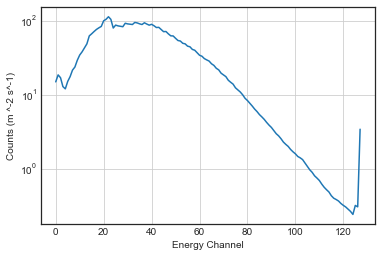

In [38]:
# sum up each 128 rows above by using dot product.
Counts_per_channel=np.dot(a, b)
#plt.plot((Counts_per_channel))
plt.ylabel('Counts (m ^-2 s^-1)')
plt.xlabel('Energy Channel')
plt.grid(True)
# TODO: Put bins
# Size of 
#plt.loglog(Counts_per_channel)
plt.semilogy(Counts_per_channel)
plt.show()

In [39]:
# Gaussian Fluctuation
#mu_True = Integration_at_energy
mu_True = NbPhoton_Sim
sigma_True = np.sqrt(mu_True)
Integration_at_energy_Gaussian_FakeData = np.random.normal(loc=mu_True, scale=sigma_True, size=None)